In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Python standard library imports
from typing import Self, Any
from random import sample

In [3]:
from numpy import ndarray

In [4]:
from matplotlib.pyplot import subplots, show

In [5]:
import os
import pandas as pd

In [6]:
#!pip install -U scikit-learn

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
# model building imports
from keras import Model, Sequential, Input

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical

In [9]:
# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

In [10]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#import cv2

In [11]:
# extraction
import zipfile
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")

print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

Extracting zip 
Extraction complete


In [12]:
# CVS FILE

csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")

Found CSV files: ['metadata.csv']
Loaded metadata with shape: (11983, 7)
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_tur

In [13]:
input_shape = (32, 32, 3) # RGB

In [14]:
data = tf.keras.utils.image_dataset_from_directory(
    'rare_species',  # Path to your dataset
    image_size=(256, 256),  # Resize the images to 256x256
    batch_size=32,  # Define the batch size
    shuffle=True  # Shuffle the data
)

Found 11983 files belonging to 202 classes.


In [15]:
n_classes=202

In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

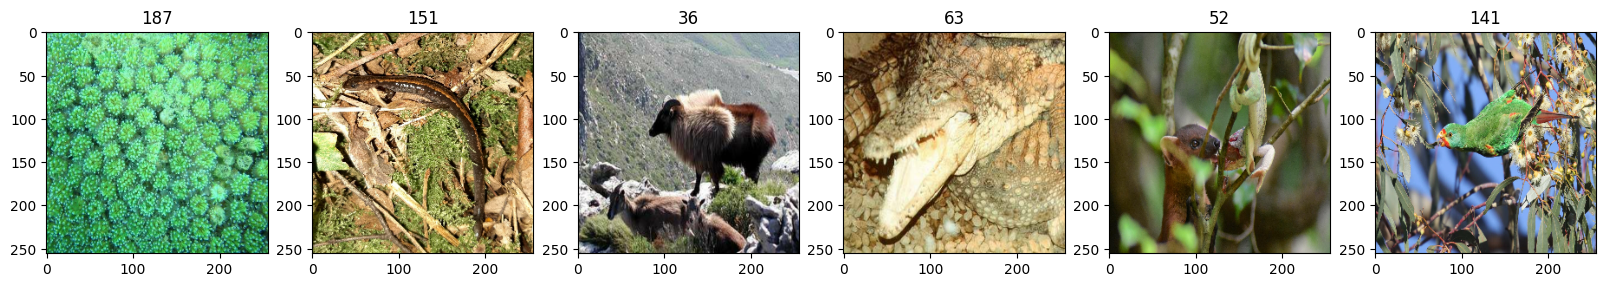

In [18]:
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### NORMALIZATION


In [19]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.9137255 , 0.92941177, 0.93333334],
          [0.92156863, 0.9372549 , 0.9411765 ],
          [0.93039215, 0.9460784 , 0.95      ],
          ...,
          [0.9490196 , 0.9607843 , 0.98039216],
          [0.9470588 , 0.9588235 , 0.97843134],
          [0.9411765 , 0.9529412 , 0.972549  ]],
 
         [[0.9254902 , 0.9254902 , 0.93333334],
          [0.92745095, 0.92745095, 0.9352941 ],
          [0.9137255 , 0.92941177, 0.93333334],
          ...,
          [0.95098037, 0.9627451 , 0.9823529 ],
          [0.9372549 , 0.96862745, 0.98039216],
          [0.95098037, 0.95098037, 0.972549  ]],
 
         [[0.9254902 , 0.9254902 , 0.93333334],
          [0.92745095, 0.92745095, 0.9352941 ],
          [0.9137255 , 0.92941177, 0.93333334],
          ...,
          [0.95098037, 0.9627451 , 0.9823529 ],
          [0.9372549 , 0.96862745, 0.98039216],
          [0.95098037, 0.95098037, 0.972549  ]],
 
         ...,
 
         [[0.74313724, 0.74313724, 0.7352941 ],
          [0.75686

### PRE PROCESSING

In [31]:
from collections import Counter
class_names = data.class_names if hasattr(data, 'class_names') else sorted(
    [folder for folder in os.listdir('rare_species') if os.path.isdir(os.path.join('rare_species', folder))]
)

# Initialize a Counter for class occurrences
class_counts = Counter()

# Iterate through the dataset to count occurrences of each class
for images, labels in data:
    # Update the counter with the labels of the current batch
    class_counts.update(labels.numpy())

# Extract the counts of each class
counts = list(class_counts.values())

# Find the median of the counts
median_count = np.median(counts)
mean_count = np.mean(counts)

# Print the median count
print(f"Median count of images per class: {median_count}")
print(f"Mean count of images per class: {mean_count}")

Median count of images per class: 30.0
Mean count of images per class: 59.32178217821782


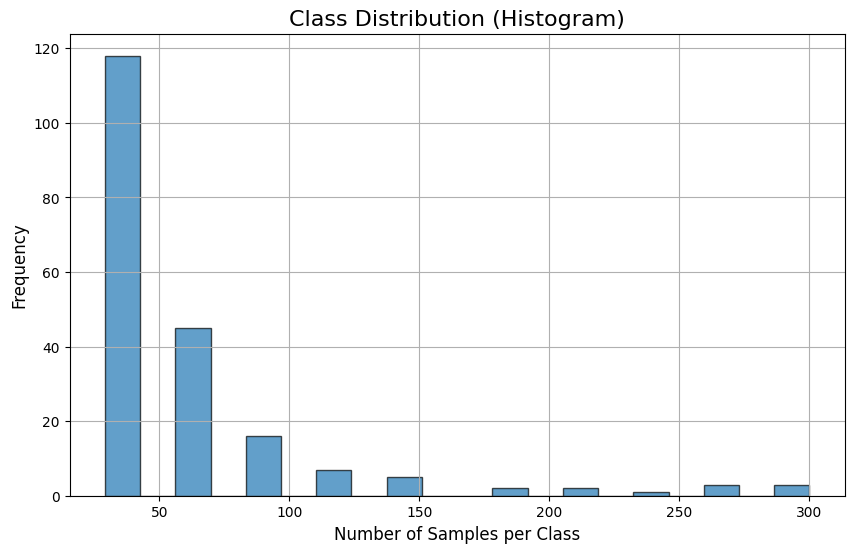

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=20, edgecolor='black', alpha=0.7)  # You can adjust the number of bins
plt.title('Class Distribution (Histogram)', fontsize=16)
plt.xlabel('Number of Samples per Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

### Augmentation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmentation strategies
datagen = ImageDataGenerator(
    rotation_range=30,        # Rotate images within a range of 30 degrees
    width_shift_range=0.2,    # Shift images horizontally
    height_shift_range=0.2,   # Shift images vertically
    shear_range=0.2,          # Apply shear transformation
    zoom_range=0.2,           # Zoom in/out on images
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest'       # Fill pixels that get moved during transformations
)

In [21]:
underrepresented_classes = [class_name for class_name, count in class_counts.items() if count < 60]
len(underrepresented_classes)

NameError: name 'class_counts' is not defined

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Load the dataset using tf.keras.utils.image_dataset_from_directory
data = tf.keras.utils.image_dataset_from_directory(
    'rare_species',  # Path to your dataset
    image_size=(256, 256),  # Resize the images to 256x256
    batch_size=32,  # Define the batch size
    shuffle=True  # Shuffle the data
)

# Step 2: Get class names (from directory structure)
class_names = data.class_names

# Step 3: Get class counts
class_counts = {}
for images, labels in data:
    for label in labels.numpy():
        class_counts[class_names[label]] = class_counts.get(class_names[label], 0) + 1
print("Class counts:", class_counts)

# Step 4: Identify underrepresented classes
underrepresented_classes = [class_name for class_name, count in class_counts.items() if count < 30]
print(f"Underrepresented classes: {underrepresented_classes}")

# Step 5: Define augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Step 6: Create a base directory to save the augmented images
save_directory = 'augmented_images/'
os.makedirs(save_directory, exist_ok=True)

# Step 7: Augment images for each underrepresented class and save them in specific folders
for class_name in underrepresented_classes:
    print(f"Augmenting images for class: {class_name}")
    
    # Step 7.1: Filter images for the current underrepresented class
    class_images = []
    class_labels = []
    
    # Collect the images belonging to the current class
    for image, label in data:
        for i in range(len(label)):
            if class_names[label[i]] == class_name:
                class_images.append(image[i].numpy())
                class_labels.append(label[i].numpy())
    
    # Step 7.2: Convert to numpy arrays
    class_images = np.array(class_images)
    class_labels = np.array(class_labels)

    # Step 7.3: Create a directory for the current class
    class_save_directory = os.path.join(save_directory, class_name)
    os.makedirs(class_save_directory, exist_ok=True)

    # Step 7.4: Augment the images using the ImageDataGenerator
    datagen.fit(class_images)
    
    # Step 7.5: Generate and save augmented images in batches
    augmented_images = datagen.flow(
        class_images, 
        class_labels, 
        batch_size=32, 
        save_to_dir=class_save_directory,  # Save in the class-specific folder
        save_prefix=class_name, 
        save_format='jpeg'
    )
    
    # Generate 10 batches and save the augmented images
    for i in range(10):  # Adjust the number of batches you want to generate
        next(augmented_images)  # Correct way to generate the next batch of augmented images

    print(f"Saved augmented images for {class_name}")

print("Data augmentation and saving complete.")


Found 11983 files belonging to 202 classes.
Class counts: {'chordata_thraupidae': 90, 'cnidaria_merulinidae': 60, 'chordata_accipitridae': 119, 'chordata_syngnathidae': 60, 'chordata_rhyacotritonidae': 60, 'chordata_otariidae': 60, 'chordata_alcedinidae': 30, 'chordata_lacertidae': 60, 'chordata_vangidae': 30, 'chordata_cacatuidae': 30, 'chordata_ranidae': 90, 'chordata_laridae': 150, 'chordata_latimeriidae': 30, 'chordata_dactyloidae': 300, 'arthropoda_tettigoniidae': 30, 'chordata_bucerotidae': 210, 'chordata_fringillidae': 60, 'chordata_cryptobranchidae': 60, 'chordata_strigopidae': 30, 'chordata_chaetodontidae': 60, 'chordata_sparidae': 60, 'chordata_glareolidae': 30, 'chordata_carcharhinidae': 270, 'chordata_soricidae': 30, 'chordata_caprimulgidae': 30, 'chordata_turdidae': 60, 'chordata_phasianidae': 30, 'chordata_plethodontidae': 270, 'chordata_scolopacidae': 60, 'chordata_ramphastidae': 30, 'chordata_cercopithecidae': 300, 'chordata_squatinidae': 30, 'chordata_carettochelyidae'

Found 11983 files belonging to 202 classes.
Median count of images per class (original dataset): 30.0
Mean count of images per class (original dataset): 59.32178217821782


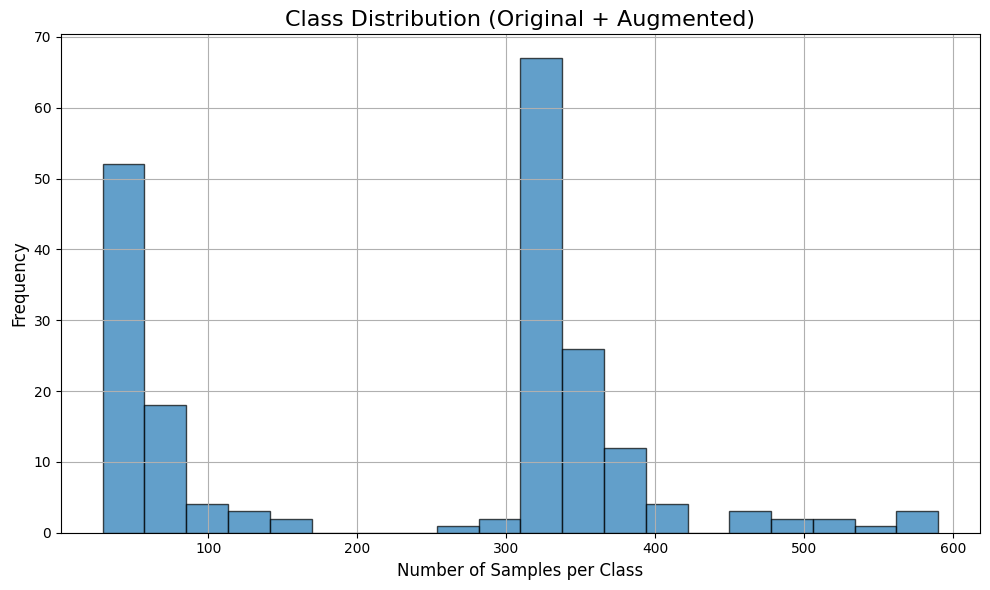

Top 5 classes with the highest total samples (original + augmented):
chordata_balaenicipitidae: 590 samples
arthropoda_tettigoniidae: 570 samples
chordata_cuculidae: 570 samples
chordata_gekkonidae: 540 samples
chordata_balaenopteridae: 510 samples


In [25]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset using tf.keras.utils.image_dataset_from_directory
data = tf.keras.utils.image_dataset_from_directory(
    'rare_species',  # Path to your dataset
    image_size=(256, 256),  # Resize the images to 256x256
    batch_size=32,  # Define the batch size
    shuffle=True  # Shuffle the data
)

# Step 1: Get class names (from directory structure)
class_names = data.class_names if hasattr(data, 'class_names') else sorted(
    [folder for folder in os.listdir('rare_species') if os.path.isdir(os.path.join('rare_species', folder))]
)

# Initialize a Counter for class occurrences
class_counts = Counter()

# Step 2: Count occurrences of each class in the original dataset
for images, labels in data:
    # Update the counter with the labels of the current batch
    class_counts.update(labels.numpy())

# Step 3: Extract counts for original dataset
original_counts = list(class_counts.values())

# Step 4: Find the median and mean of the counts
median_count = np.median(original_counts)
mean_count = np.mean(original_counts)

# Print the median and mean counts
print(f"Median count of images per class (original dataset): {median_count}")
print(f"Mean count of images per class (original dataset): {mean_count}")

# Step 5: Count augmented images
augmented_class_counts = {class_name: 0 for class_name in class_names}
augmented_images_base_dir = 'augmented_images'

# Count the number of augmented images in each class directory
for class_name in class_names:
    class_dir = os.path.join(augmented_images_base_dir, class_name)
    if os.path.exists(class_dir):
        augmented_class_counts[class_name] = len(os.listdir(class_dir))

# Step 6: Calculate total counts (original + augmented)
total_counts = {class_name: original_counts[i] + augmented_class_counts[class_name]
                for i, class_name in enumerate(class_names)}

# Step 7: Prepare data for plotting
total_counts_list = [total_counts[class_name] for class_name in class_names]

# Step 8: Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(total_counts_list, bins=20, edgecolor='black', alpha=0.7)  # Adjust bins as needed
plt.title('Class Distribution (Original + Augmented)', fontsize=16)
plt.xlabel('Number of Samples per Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Print the total counts of the top few classes (for reference)
print("Top 5 classes with the highest total samples (original + augmented):")
sorted_classes = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)
for class_name, total in sorted_classes[:5]:
    print(f"{class_name}: {total} samples")


### TESTING THE TRAIN TEST SPLIT AND THE MODELS (DONT WORRY ABOUT IT NOW)

In [19]:
# Split the dataset into training and test sets manually
train_size = int(0.8 * len(data))  # 80% for training
test_size = len(data) - train_size  # 20% for testing

# Split the data into training and test sets
train_data = data.take(train_size)
test_data = data.skip(train_size)

# Function to process data in batches and convert to NumPy arrays
def process_batch(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert to NumPy
        labels.append(label_batch.numpy())  # Convert to NumPy
    images = np.concatenate(images, axis=0)  # Concatenate all images
    labels = np.concatenate(labels, axis=0)  # Concatenate all labels
    return images, labels

# Process the training and test batches
X_train, y_train = process_batch(train_data)
X_test, y_test = process_batch(test_data)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=202)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=202)

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (9600, 256, 256, 3), y_train shape: (9600, 202)
X_test shape: (2383, 256, 256, 3), y_test shape: (2383, 202)


In [49]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (9586, 256, 256, 3), y_train shape: (9586,)
X_test shape: (2397, 256, 256, 3), y_test shape: (2397,)


# Split Data

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Training the Model

In [20]:
model = Sequential(
    layers = [
        Input(shape=input_shape),
        Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        # input size is infered
        Dense(n_classes, activation="softmax"),
    ],
    name = "my_tiny_sequential_cnn"
)

model.summary()

Model: "my_tiny_sequential_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 24)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │       349,258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,346 (1.37 MB)

 Trainable params: 360,346 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def get_my_tiny_functional_cnn() -> Model:
    """
    Constructs "my_tiny_functional_cnn"
    """

    conv_layer_1 = Conv2D(
        filters=3 * 8,
        kernel_size=(3, 3),
        activation="relu",
        name="conv_layer_1"
    )
    max_pool_layer_1 = MaxPooling2D(pool_size=(2, 2), name="max_pool_layer_1")

    conv_layer_2 = Conv2D(
        filters=3 * 16,
        kernel_size=(3, 3),
        name="conv_layer_2"
    )
    act_layer_2 = LeakyReLU(negative_slope=0.3, name="act_layer_2")
    max_pool_layer_2 = MaxPooling2D(pool_size=(2, 2), name="max_pool_layer_2")

    flatten_layer = Flatten(name="flatten_layer")
    dense_layer = Dense(
        n_classes,
        activation="softmax",
        name="classification_head"
    )


    inputs = Input(shape=input_shape)
    x = inputs

    x = conv_layer_1(x)
    x = max_pool_layer_1(x)

    x = conv_layer_2(x)
    x = act_layer_2(x)
    x = max_pool_layer_2(x)

    x = flatten_layer(x)
    x = dense_layer(x)

    outputs = x

    return Model(inputs=inputs, outputs=outputs, name="my_tiny_functional_cnn")

In [22]:
model = get_my_tiny_functional_cnn()
model.summary()

Model: "my_tiny_functional_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 30, 30, 24)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_layer_1 (MaxPooling2D) │ (None, 15, 15, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 13, 13, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_layer_2 (LeakyReLU)         │ (None, 13, 13, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_layer_2 (MaxPooling2D) │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ (None, 202)            │       349,258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,346 (1.37 MB)

 Trainable params: 360,346 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
class MyTinyCNN(Model):
    """
    MyTinyCNN class, inherets from keras' Model class
    """

    def __init__(self: Self, activation: str = "relu") -> None:
        """
        Initialization
        """

        super().__init__(name="my_tiny_oo_cnn")

        self.conv_layer_1 = Conv2D(
            filters=3 * 8,
            kernel_size=(3, 3),
            activation=activation,
            name="conv_layer_1"
        )
        self.max_pool_layer_1 = MaxPooling2D(
            pool_size=(2, 2),
            name="max_pool_layer_1"
        )

        # exemplify non-sequential nature of computation possible with
        # the functional and object-oriented methods
        self.conv_layer_2l = Conv2D(
            filters=3 * 16,
            kernel_size=(3, 3),
            activation=activation,
            name="conv_layer_2l",
            padding="same"
        )
        self.conv_layer_2r = Conv2D(
            filters=3 * 16,
            kernel_size=(2, 2),
            activation=activation,
            name="conv_layer_2r",
            padding="same"
        )
        self.max_pool_layer_2 = MaxPooling2D(
            pool_size=(2, 2),
            name="max_pool_layer_2"
        )

        self.flatten_layer = Flatten(name="flatten_layer")
        self.dense_layer = Dense(
            n_classes,
            activation="softmax",
            name="classification_head"
        )

    def call(self: Self, inputs: Any) -> Any:
        """
        Forward call
        """

        x = inputs

        x = self.conv_layer_1(x)
        x = self.max_pool_layer_1(x)

        # exemplify non-sequential nature of computation possible with
        # the functional and object-oriented methods
        x_l = self.conv_layer_2l(x)
        x_r = self.conv_layer_2r(x)
        x = add(x_l, x_r)
        x = self.max_pool_layer_2(x)

        x = self.flatten_layer(x)

        return  self.dense_layer(x)

In [24]:
# no output shape and number of parameters specified, why?
model = MyTinyCNN()
model.summary()

# inputs = Input(shape=input_shape)
# _ = model.call(inputs)
# model.summary()

Model: "my_tiny_oo_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_layer_1 (Conv2D)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_layer_1 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2l (Conv2D)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2r (Conv2D)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_layer_2 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs = 32
batch_size = 16

In [26]:
# What do we need? Model, optimizer, loss (at least)
model = MyTinyCNN()
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

# traces the computation
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [27]:
# train the model
_ = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/32
480/480 ━━━━━━━━━━━━━━━━━━━━ 147s 300ms/step - accuracy: 0.0410 - auc: 0.6460 - f1_score: 0.0042 - loss: 5.1322 - val_accuracy: 0.1000 - val_auc: 0.7166 - val_f1_score: 0.0110 - val_loss: 4.7508
Epoch 2/32
480/480 ━━━━━━━━━━━━━━━━━━━━ 129s 270ms/step - accuracy: 0.0959 - auc: 0.7488 - f1_score: 0.0201 - loss: 4.6065 - val_accuracy: 0.1240 - val_auc: 0.7626 - val_f1_score: 0.0390 - val_loss: 4.5040
Epoch 3/32
480/480 ━━━━━━━━━━━━━━━━━━━━ 133s 276ms/step - accuracy: 0.1736 - auc: 0.8415 - f1_score: 0.0778 - loss: 3.9811 - val_accuracy: 0.1339 - val_auc: 0.7697 - val_f1_score: 0.0554 - val_loss: 4.5088
Epoch 4/32
480/480 ━━━━━━━━━━━━━━━━━━━━ 132s 275ms/step - accuracy: 0.3391 - auc: 0.9265 - f1_score: 0.2756 - loss: 2.9662 - val_accuracy: 0.1745 - val_auc: 0.7619 - val_f1_score: 0.1080 - val_loss: 4.4966
Epoch 5/32
480/480 ━━━━━━━━━━━━━━━━━━━━ 134s 279ms/step - accuracy: 0.7105 - auc: 0.9809 - f1_score: 0.7031 - loss: 1.3672 - val_accuracy: 0.1547 - val_auc: 0.7265 - val_f1_sco

In [28]:
# evaluate on the test set
model.evaluate(
    X_test,
    y_test,
    batch_size=batch_size,
    return_dict=True,
    verbose=0
)

{'accuracy': 0.1791858971118927,
 'auc': 0.6692543029785156,
 'f1_score': 0.12632745504379272,
 'loss': 8.699676513671875}